In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.linalg import toeplitz, svdvals, pinv
from scipy.sparse import spdiags
from scipy.optimize import fminbound

from functools import partial

Provide equally spaced points centered about the origin. 

In [2]:
def grid(number_of_points, center): 
    return np.arange(-number_of_points / 2 + center, number_of_points / 2 + 1 + center)

t = grid(128, 0) 

## Forward Direction

### Construct latent signal. 

In [3]:
latent_signal = np.piecewise(t, [t < -t.size / 6, t >= -t.size / 6, t >= t.size / 6], [0, 1, 0])

### Build Kernel Operator

In [4]:
def normal_distribution(t, mean, standard_deviation): 
    gaussian = np.exp(-0.5 * ((t - mean) / standard_deviation)**2)
    return gaussian / sum(gaussian)

def derivative_wrt_mean(t, mean, standard_deviation):
    if mean == 0: 
        return np.zeros_like(t)
    return np.exp(-(t-mean) ** 2 / (2 * standard_deviation ** 2)) * ((t-mean) / (standard_deviation**2))

def derivative_wrt_standard_deviation(t, mean, standard_deviation): 
    return np.exp(-(t-mean)**2 / (2 * standard_deviation ** 2)) * ((t-mean)**2) / (standard_deviation**3)

def toeplitz_structure(c, k): 
    n = c.size
    col = np.zeros_like(c)
    row = np.zeros_like(c)
    col[0:k+1] = c[k::1]
    row[0:k+1] = c[k::-1]
    return toeplitz(col, row)

def mixture_components(domain, parameters, components):
    return np.array([component(domain, *parameter) / sum(component(domain, *parameter)) for parameter, component in zip(parameters, components)])

In [5]:
class BlurringOperator(): 
    def __init__(self, kernel, structure):
        self.kernel = kernel
        self.structure = structure

    @property    
    def matrix(self):
        return self.structure(self.kernel, self.kernel.size // 2)
    
    def __matmul__(self, other): 
        return self.matrix @ other

In [6]:
class MixtureDistribution(): 
    def __init__(self, domain, weights, parameters, components, component_derivatives):
        self.domain = domain 
        self.weights = weights 
        self.parameters = parameters 
        self.components = [partial(component, domain) for component in components]
        self.component_derivatives = [partial(derivative, domain) for derivative in component_derivatives]
    
    @property
    def array(self): 
        return self.weights @ self.components_array

    def normalized_component_array(self, component, parameter): 
        return component(*parameter) / sum(component(*parameter))
    
    @property
    def components_array(self): 
        return np.array(
            [self.normalized_component_array(component, parameter) for parameter, component in zip(self.parameters, self.components)]
        )

    @property
    def component_derivatives_array(self): 
        result = []
        for derivative, parameter in zip(self.component_derivatives, self.parameters): 
            result.append(derivative(*parameter))
        return np.array(result)

    @property
    def partial_derivative_wrt_parameters(self):
        result = []
        for weight in self.weights:
            for component, component_derivative, parameter in zip(self.components, self.component_derivatives, self.parameters):
                component = component(*parameter)
                component_derivative = component_derivative(*parameter)
                sum_component = sum(component)
                sum_derivative = sum(component_derivative)
                result.append(
                    weight * (component_derivative / sum_component - (component * sum_derivative / (sum_component ** 2)))
                )
        return result 

    @property
    def partial_derivative_wrt_weights(self): 
        return [self.normalized_component_array(component, parameter) for parameter, component in zip(self.parameters, self.components)]

    def visualize_mixture(self): 
        fig, ax = plt.subplots()
        ax.plot(self.domain, self.array, 'k', label='Mixture Distribution')
        for weight, component_array, component in zip(self.weights, self.components_array, self.components):
            ax.plot(self.domain, weight * component_array, 'k:', label=component.func.__name__)
        ax.set_xlabel('Pixels')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
    
    def __repr__(self) -> str:
        return f'''MixtureDistribution(
    domain = {[self.domain[0], self.domain[-1]]}, 
    weights = {self.weights},
    parameters = {self.parameters},
    components = {self.components},
    component_derivatives = {self.component_derivatives}
        )'''

In [7]:
weights = np.array([0.5, 0.5])
means = np.array([0, 0])
standard_deviations = np.array([10, 20])
parameters = np.column_stack((means, standard_deviations))
partial_derivatives_of_components_wrt_paramaters = [
    derivative_wrt_mean, 
    derivative_wrt_standard_deviation
]
mixture_model = MixtureDistribution(
    t, 
    weights, 
    parameters, 
    [normal_distribution for _ in parameters], 
    partial_derivatives_of_components_wrt_paramaters
)
blur = BlurringOperator(mixture_model.array, toeplitz_structure)

### Blur Latent Signal & Add Noise

In [8]:
def guassian_noise(percentage, latent_signal):
    np.random.seed(1)
    return np.random.normal(0, latent_signal.std(), latent_signal.size) * percentage

percentage = 0.05
noise = guassian_noise(percentage, latent_signal)
data = blur @ latent_signal + noise

### Plotting. 

See [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html#examples-using-matplotlib-gridspec-gridspec) for more details. 

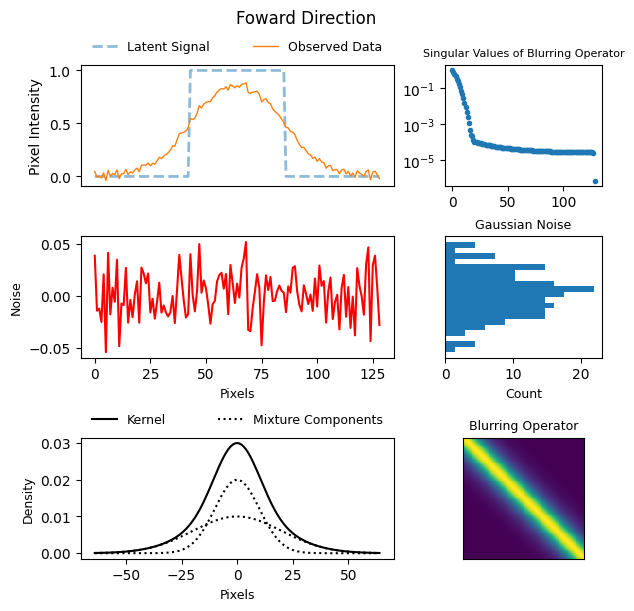

In [9]:
fig = plt.figure(layout="constrained",figsize=(6,6))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[-1, :2])
ax3 = fig.add_subplot(gs[1, :-1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1,2])

ax6 = fig.add_subplot(gs[-1,2])

ax1.plot(t, latent_signal, '--', linewidth='2', alpha=0.5, label='Latent Signal')
ax1.plot(t, data, linewidth=1, label='Observed Data')
ax1.legend(bbox_to_anchor=(0,1,1,.1), ncol=2, mode='expand', loc='lower left', framealpha=0, fontsize=9)
ax1.set_ylabel('Pixel Intensity')
ax1.tick_params(bottom=False, labelbottom=False)

ax2.plot(t, mixture_model.array, 'k', label='Kernel')
ax2.plot(t, weights[0] * mixture_model.components_array[0], 'k:', label='Mixture Components')
ax2.plot(t, weights[1] * mixture_model.components_array[1], 'k:')
ax2.set_ylabel('Density', fontsize=9)
ax2.set_xlabel('Pixels', fontsize=9)
ax2.legend(bbox_to_anchor=(0,1,1,.1), ncol=2, mode='expand', loc='lower left', framealpha=0, fontsize=9)

ax3.plot(noise, 'r', label='Noise')
ax3.set_xlabel('Pixels', fontsize=9)
ax3.set_ylabel('Noise', fontsize=9)

ax4.semilogy(svdvals(blur.matrix), '.')
ax4.set_title('Singular Values of Blurring Operator', fontsize=8)

count, bins, ignored = ax5.hist(noise, 20, density=True, orientation='horizontal')
ax5.tick_params(labelleft=False, left=False)
ax5.set_xlabel('Count', fontsize=9)
ax5.set_title('Gaussian Noise', fontsize=9)

ax6.matshow(blur.matrix)
ax6.set_title('Blurring Operator', fontsize=9)
ax6.tick_params(labeltop=False, labelleft=False, top=False, left=False, bottom=False)

fig.suptitle("Foward Direction")

plt.show()

### Inverse Problem

Use the variable projection method to find the latent signal.

In [10]:
def total_variation(x): 
    BETA = 1e-16
    differential_operator = forward_difference_matrix(x)
    return np.diag((1/(((differential_operator*x)**2 + BETA**2)**(1/4)))) @ differential_operator

def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size)

def rjf_jacobian(signal, partial_derivatives, structure): 
    result = []
    for partial_derivative in partial_derivatives:
            block = structure(partial_derivative, partial_derivative.size // 2)
            result.append(
                 block @ signal 
            )
    return np.array(result).T

def objective_function(blurring_operator, signal, data, regularization_parameter, regularization_matrix):
    norm = np.linalg.norm 
    K = blurring_operator
    x = signal 
    d = data 
    gamma = regularization_parameter
    L = regularization_matrix
    return norm(K @ x - d) ** 2 + gamma ** 2 * norm(L @ x) ** 2

def line_search(alpha, function, delta_y, mixture_model, blurring_operator): 
    y = np.hstack((mixture_model.weights, mixture_model.parameters.flatten()))
    line = y + alpha * delta_y
    mixture_model.weights = line[0:mixture_model.weights.size] 
    parameters = line[mixture_model.weights.size:mixture_model.weights.size + 1 + mixture_model.parameters.size]
    mixture_model.parameters = parameters.reshape(mixture_model.parameters.shape)
    blurring_operator.kernel = mixture_model.array
    return function(blurring_operator)


def variable_projection_total_variation(
        data, 
        initial_signal,
        initial_mixture_model,
        blur_structure,
        jacobian,
        regularization_parameter,
        regularization_matrix,
        max_iterations, 
        tolerance
    ): 
    L = regularization_matrix(initial_signal)
    mixture_model = initial_mixture_model

    y = np.hstack((mixture_model.weights, mixture_model.parameters.flatten()))
    for _ in range(max_iterations): 
        kernel = mixture_model.array
        kernel_partial_derivatives = mixture_model.partial_derivative_wrt_weights + mixture_model.partial_derivative_wrt_parameters
        K = BlurringOperator(kernel, blur_structure)

        KL = np.block([[K.matrix], [regularization_parameter * L]])
        bigd = np.block([data, np.zeros_like(data)])
        signal = pinv(KL) @ bigd

        J = jacobian(signal, kernel_partial_derivatives, blur_structure)
        # Gauss-Newton method for least squares 
        residual = data - K @ signal
        delta_y = pinv(J) @ residual
        # line search strategy
        full_functional = partial(objective_function, signal=signal, data=data, regularization_parameter=regularization_parameter, regularization_matrix=L)
        search = partial(line_search, function=full_functional, delta_y=delta_y, mixture_model=mixture_model, blurring_operator=K)
 
        alpha = fminbound(search, 0, 1)
        y = y + alpha * delta_y

        weights = y[0:mixture_model.weights.size]
        parameters = y[mixture_model.weights.size:mixture_model.weights.size + 1 + mixture_model.parameters.size]
        
        # normalize weights 
        sum_weights = np.sum(np.abs(weights))
        weights = np.abs(weights) / sum_weights

        # update mixture model
        mixture_model.weights = weights 
        mixture_model.parameters = parameters.reshape(mixture_model.parameters.shape)
    return mixture_model 


In [11]:

mixture_model = variable_projection_total_variation( 
    data, 
    initial_signal=latent_signal, 
    initial_mixture_model=mixture_model, 
    blur_structure=partial(toeplitz_structure), 
    jacobian=rjf_jacobian,
    regularization_parameter=0.1, 
    regularization_matrix=total_variation,
    max_iterations=1, 
    tolerance=1
)

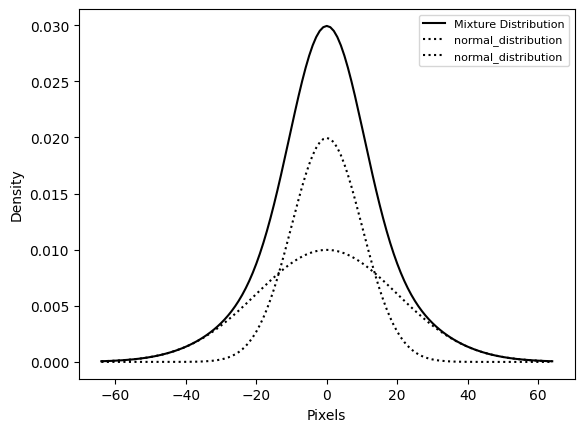

In [12]:
mixture_model.visualize_mixture()
